In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
from sklearn.datasets import fetch_openml
from sklearn.utils import check_random_state
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder

In [2]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
# The GPU id to use, usually either "0" or "1"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"   
gpus = tf.config.experimental.list_physical_devices(device_type='GPU')
print(gpus)
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu,True)#动态分配gpu别让tf一下占满

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


获取并打乱数据集

In [3]:
X,Y = fetch_openml('mnist_784',version = 1,return_X_y= True)

In [4]:
print(np.shape(X))#稍微注意两种用法
print(X.shape)
print(np.shape(X[0]))#稍微注意两种用法的区别
X.shape[0]

(70000, 784)
(70000, 784)
(784,)


70000

In [5]:
random_state = check_random_state(233)
p = random_state.permutation(X.shape[0])
X = X[p]
Y = Y[p]

数据集分割标准化 输出样例

In [6]:
train_sample = 20000
test_sample = 10000
trainX,testX,trainY,testY = train_test_split(X,Y,train_size =train_sample, test_size = test_sample )

In [7]:
scaler = StandardScaler()
trainX = scaler.fit_transform(trainX)
testX = scaler.fit_transform(testX)

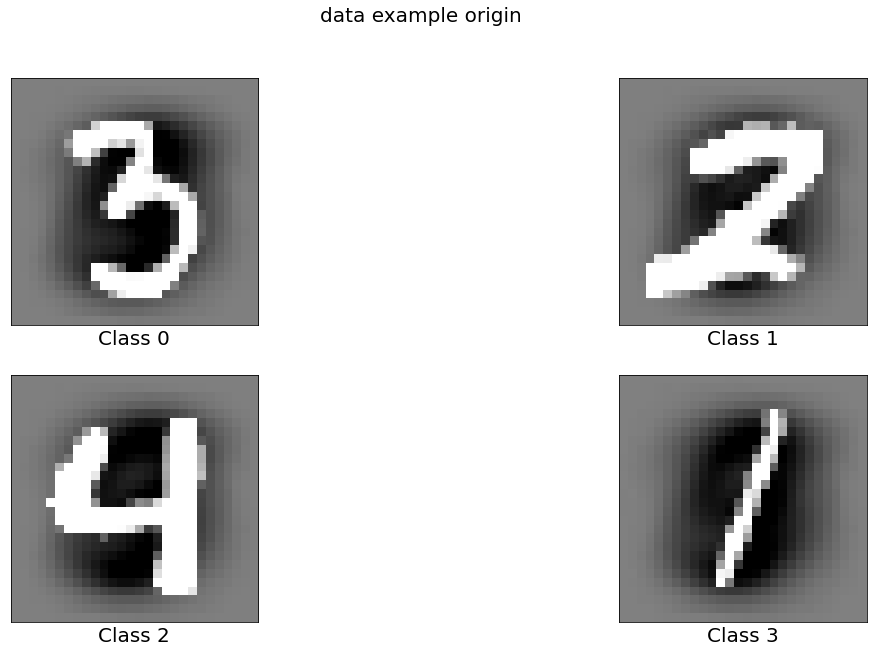

In [8]:
plt.figure(figsize=(20,10))
for i in range(4):
    pl1 = plt.subplot(2,2,i+1)
    pl1.imshow(trainX[i].reshape(28,28),interpolation = 'nearest',
              vmin = -1,vmax = 1,cmap = 'gray')
    pl1.set_xticks(())
    pl1.set_yticks(())
    pl1.set_xlabel('Class %i'%i,fontsize = 20)
plt.suptitle("data example origin",fontsize =20)
plt.show()

In [9]:
trainX = trainX.reshape(-1,28,28,1)
testX = testX.reshape(-1,28,28,1)
print(trainX.shape)
print(trainY.shape)
print(testX.shape)
print(testY.shape)
print(trainY[:10])

(20000, 28, 28, 1)
(20000,)
(10000, 28, 28, 1)
(10000,)
['3' '2' '4' '1' '7' '9' '7' '0' '3' '4']


In [10]:
le = LabelEncoder().fit(trainY)
print(list(le.classes_))
print(trainY[0:100])
trainY = tf.keras.utils.to_categorical(le.transform(trainY), 10)  # 2是num_class表示输出的是2列数据的意思
print(trainY.shape)

['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
['3' '2' '4' '1' '7' '9' '7' '0' '3' '4' '8' '5' '5' '6' '6' '9' '2' '7'
 '9' '5' '5' '4' '3' '4' '7' '9' '6' '7' '7' '0' '9' '0' '8' '4' '6' '8'
 '7' '0' '7' '8' '4' '2' '2' '3' '3' '1' '5' '8' '5' '8' '2' '1' '9' '7'
 '3' '7' '6' '4' '0' '2' '8' '0' '2' '3' '6' '5' '2' '9' '4' '1' '9' '8'
 '4' '8' '1' '7' '5' '7' '6' '0' '1' '3' '0' '6' '8' '5' '0' '6' '0' '0'
 '4' '9' '2' '3' '7' '7' '1' '6' '1' '7']
(20000, 10)


In [11]:
testY = tf.keras.utils.to_categorical(le.transform(testY), 10)
print(testY[0:5])

[[0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]]


In [12]:
index = [i for i in range(len(trainX))]
np.random.seed(43)#43 控制shuffle打乱次序为43号
np.random.shuffle(index)
trainX = trainX[index]
trainY = trainY[index]

In [13]:
index = [i for i in range(len(testX))]
np.random.seed(42)
np.random.shuffle(index)
testX = testX[index]
testY = testY[index]

In [14]:
def VGG(nb_classes, input_shape):
    input_tensor = layers.Input(shape=input_shape)
    # 1st block
    x = layers.Conv2D(32, (3,3), activation='relu', padding='same',name='conv1a')(input_tensor)
    x = layers.MaxPooling2D((2,2), strides=None, name = 'pool1')(x)
   
    # 3rd block
    # 5th block
#     x = layers.Conv2D(256, (3,3), activation='relu', padding='same',name='conv5a')(x)
#     x = layers.Conv2D(256, (3,3), activation='relu', padding='same',name='conv5b')(x)
#     x = layers.Conv2D(256, (3,3), activation='relu', padding='same',name='conv5c')(x)
#     x = layers.Conv2D(256, (3,3), activation='relu', padding='same',name='conv5d')(x)
#     x = layers.MaxPooling2D((2,2), strides=None, name = 'pool5')(x)
    # full connection
    x = layers.Flatten()(x)
    x = layers.Dense(512, activation='relu',  name='fc6')(x)
    x = layers.Dropout(0.5)(x)
    x = layers.Dense(256, activation='relu', name='fc7')(x)
    x = layers.Dropout(0.5)(x)
    output_tensor = layers.Dense(nb_classes, activation='softmax', name='fc8')(x)
    base_model = tf.keras.Model(input_tensor,output_tensor)
    return base_model

In [15]:
base_model=VGG(len(trainY[-1]), trainX[0].shape)
base_model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv1a (Conv2D)              (None, 28, 28, 32)        320       
_________________________________________________________________
pool1 (MaxPooling2D)         (None, 14, 14, 32)        0         
_________________________________________________________________
flatten (Flatten)            (None, 6272)              0         
_________________________________________________________________
fc6 (Dense)                  (None, 512)               3211776   
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
fc7 (Dense)                  (None, 256)               131328

In [16]:
adam = tf.keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
base_model.compile(loss = "binary_crossentropy", optimizer = adam, metrics = ["accuracy","AUC"])

In [17]:
# class LossHistory(tf.keras.callbacks.Callback):
#     def on_train_begin(self, logs={}):
#         self.losses = []
#         self.lr = []
        
#     def on_epoch_end(self, batch, logs={}):
#         self.losses.append(logs.get('loss'))
#         self.lr.append(step_decay(len(self.losses)))
#         print('lr:', step_decay(len(self.losses)))
# def step_decay(epoch):
#     init_lrate = 0.001#初始学习率定为0.1（较高）
#     drop = 0.5#学习率降低50%
#     epochs_drop = 100#没10个epochs降低一次
#     lrate = init_lrate * pow(drop, math.floor(1 + epoch) / epochs_drop)
#     return lrate
# loss_history = LossHistory()
# lrate = LearningRateScheduler(step_decay)


# plateau = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',
#                             verbose=0,
#                             mode='min',
#                             factor=0.7,
#                             patience=5)

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='loss',
                               verbose=0,
                               mode='min',
                               patience=50)

callbacks_list = [early_stopping]

In [18]:
H = base_model.fit(trainX,trainY,batch_size = 64, epochs = 100, validation_data=(testX,testY) ,callbacks = callbacks_list, verbose=2)  #verbose = 1显示进度条

Train on 20000 samples, validate on 10000 samples
Epoch 1/100
20000/20000 - 3s - loss: 0.0845 - accuracy: 0.9713 - AUC: 0.9821 - val_loss: 0.0331 - val_accuracy: 0.9896 - val_AUC: 0.9955
Epoch 2/100
20000/20000 - 1s - loss: 0.0386 - accuracy: 0.9883 - AUC: 0.9938 - val_loss: 0.0279 - val_accuracy: 0.9918 - val_AUC: 0.9963
Epoch 3/100
20000/20000 - 1s - loss: 0.0308 - accuracy: 0.9910 - AUC: 0.9956 - val_loss: 0.0251 - val_accuracy: 0.9925 - val_AUC: 0.9968
Epoch 4/100
20000/20000 - 1s - loss: 0.0237 - accuracy: 0.9933 - AUC: 0.9969 - val_loss: 0.0211 - val_accuracy: 0.9941 - val_AUC: 0.9972
Epoch 5/100
20000/20000 - 1s - loss: 0.0211 - accuracy: 0.9942 - AUC: 0.9972 - val_loss: 0.0205 - val_accuracy: 0.9943 - val_AUC: 0.9968
Epoch 6/100
20000/20000 - 1s - loss: 0.0189 - accuracy: 0.9950 - AUC: 0.9977 - val_loss: 0.0209 - val_accuracy: 0.9946 - val_AUC: 0.9966
Epoch 7/100
20000/20000 - 1s - loss: 0.0161 - accuracy: 0.9953 - AUC: 0.9980 - val_loss: 0.0222 - val_accuracy: 0.9947 - val_AUC

dict_keys(['loss', 'accuracy', 'AUC', 'val_loss', 'val_accuracy', 'val_AUC'])


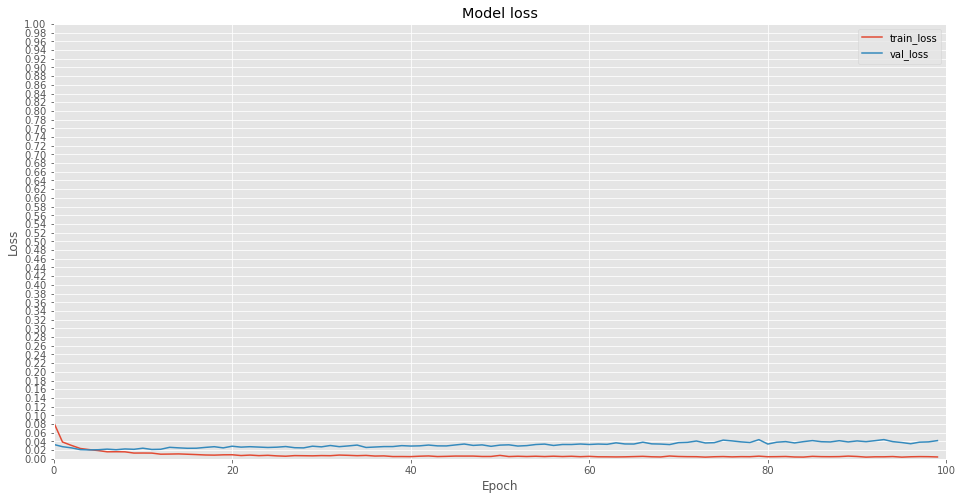

In [19]:
from matplotlib.pyplot import MultipleLocator
print(H.history.keys())
plt.style.use("ggplot")
plt.figure(figsize=(16,8))
# plt.plot(np.arange(0, 200), H.history["loss"], label = "train_loss")
# plt.plot(np.arange(0, 200), H.history["val_loss"], label = "val_loss")
plt.plot(np.arange(0, 100), H.history["loss"], label = "train_loss")
plt.plot(np.arange(0, 100), H.history["val_loss"], label = "val_loss")
plt.title("Model loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
x_major_locator=MultipleLocator(20)
y_major_locator=MultipleLocator(0.02)
ax=plt.gca()
#ax为两条坐标轴的实例
ax.xaxis.set_major_locator(x_major_locator)
#把x轴的主刻度设置为1的倍数
ax.yaxis.set_major_locator(y_major_locator)
plt.xlim(0,100)
#把x轴的刻度范围设置为-0.5到11，因为0.5不满一个刻度间隔，所以数字不会显示出来，但是能看到一点空白
plt.ylim(0,1)

plt.legend(['train_loss','val_loss'],loc='upper right')
plt.show()

In [21]:
from sklearn.metrics import classification_report
predictions = base_model.predict(testX, batch_size = 64)
print(np.shape(predictions))
print(predictions.argmax(axis =1))
print(testY.argmax(axis = 1).shape)
leclass = [str(i) for i in le.classes_]
print(leclass)
print(classification_report(testY.argmax(axis = 1), predictions.argmax(axis = 1),
                           target_names = leclass,digits=3))

(10000, 10)
[4 2 4 ... 9 1 1]
(10000,)
['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
              precision    recall  f1-score   support

           0      0.987     0.989     0.988       997
           1      0.992     0.987     0.989      1135
           2      0.953     0.974     0.963       989
           3      0.980     0.975     0.978      1013
           4      0.977     0.978     0.978       957
           5      0.992     0.956     0.973       858
           6      0.977     0.985     0.981       972
           7      0.972     0.979     0.975      1075
           8      0.967     0.969     0.968       995
           9      0.970     0.970     0.970      1009

    accuracy                          0.977     10000
   macro avg      0.977     0.976     0.976     10000
weighted avg      0.977     0.977     0.977     10000

